<a href="https://colab.research.google.com/github/Shahid1993/colab-notebooks/blob/master/conditional_gen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Building Gmail style smart compose with a char ngram language model](https://towardsdatascience.com/gmail-style-smart-compose-using-char-n-gram-language-models-a73c09550447)

### Let’s build a simple and powerful language model from scratch and use it for text generation.

If you are a Gmail user, by now you would have experienced the *smart compose* feature. It’s the new automatic sentence completion feature that takes email productivity to an exciting new level. It was released in Google I/O 2018. 

## Smart compose is smarter than you think

**Whatsapp** offers a predictive text and **Google search** auto completes our queries with trending searches as you type in. Overall both offer a simple **model based prefix search**, i.e the text typed in by the user is used as the prefix to predict the next word the user might want to type (in Whatsapp’s case) or user’s search intent (in the Google search case). **Smart compose** is a nifty extension of predictive text and auto complete, but there is more to it.

### Whatsapp Predictive Text
Whatsapp predicts the next possible word and presents you with the top 3 possibilities. While it is model based, it only predicts the next word (unigram) or at most the next word pair (a bigram), but nothing further.

![](https://miro.medium.com/max/1806/1*yMsFXA67-B8JOn11bOBM3g.png)

### Google autocomplete
The query autocomplete (shown below) is also a model based solution that factors in the search phrase typed in so far and runs a prefix search on the trending searches.

![](https://miro.medium.com/max/654/1*_pJzicw2R8Ki6Y-dYdT-jQ.gif)

### Smart compose
Word level predictive texts are great, but they are a great fit only where the user inputs come in short spurts. But with emails, the user is going to type in a lot of text in one go across multiple emails. So lesser the user needs to type, the greater the user experience and productivity. Also, In emails if you look close, we end up repeating lot of sentences, from greetings to basic pleasantries to closure notes.

Smart compose not only uses the current text, it uses the subject and the previous message (if the user is replying) to complete the sentence for you.

### Motivation

NMT (Neural Machine Translation) has sort of become the canonical use case for explaining sequence to sequence models (Seq2Seq models). While there is nothing wrong in that, IMHO NMT doesn’t do justice to all the magic the Seq2Seq paradigm can offer. Besides MT (Machine Translation) is not a well solved problem (at least as of this writing). But look at smart email response (Kannan et al., 2016) and smart compose (gmail), they are practical solutions that work really well.

## Language models, RNNs and Seq2Seq Modelling

### Language models: Intuition

The modern incarnation of a Language Model (LM) is a critical milestone in the progression of NLP as a field . So, let’s start by understanding the intuition behind a LM.

![](https://miro.medium.com/max/1024/1*yxbmLf7Rv9z-bRGThgSaVw.png)

LMs learn a representation of a text corpus similar to a word embedding but better one. Now, What do I mean by that ? Simply put, the goal of a LM is to break up a text corpus and assign probabilities to text sequences, typically one word at a time.(but there are other variants).

So, how does this work ? For a text sequence _“The dog barked at the stranger”_ in our corpus, a word based LM estimates the probability of P(_“The dog barked at the stranger”_) one word at a time using the chain rule of probability. It starts with the probability of the first word(“The”) and continues with, the probability of second word(“dog”) given the first word(“The”) and then goes on to the probability of the third word given the first & second word and so on. Mathematically speaking the LM estimates the following,

![](https://miro.medium.com/max/1338/1*hjhcaY4Rir_kQv5ZNeJIMA.png)

Concretely, a LM estimates the following, where n is the number of words.

![](https://miro.medium.com/max/1296/1*EbyWjo-Nvmbnbv2-a4opRg.png)

LMs have many different use cases. One of it is, A LM can tell how probable a text sequence is for a given corpus. For instance, a text sequence **P(“A dog flew upside down without wings)** will yield a very low probability unless the text corpus came out of some fiction novel. But this use case is less interesting to us. What is more interesting is, LMs are a natural fit for sequence generation (in this case text generation).

1. We can ask a LM to generate a random sequence of arbitrary length with or without **prefix** (also referred as **seed** or **prompt** sometimes). The prefix or prompt can be anything, a word or another sequence of arbitrary length. For instance, we can prompt a LM with a word to generate a random sentence or we can prompt a LM with a sentence to generate a sentence or a paragraph. _The special case of generating an arbitrary length sequence given a arbitrary length sequence as input is called **conditioned generation**, as the output is conditioned on the input. That is in fact why this paradigm is called Seq2Seq modelling._ Machine Translation is the canonical example of conditioned generation because it is easy to drive the point to the readers. So, shown below is a layout of a classical Seq2Seq model where _**x1,x2…xn**_ being the input sequence and _**y1,y2..ym**_ being the output sequence. (\<start> and \<end> are teacher forcing delimiters)

![Layout of an RNN based Conditioned Generator](https://miro.medium.com/max/2236/1*b0ycohanqi_2jYyRMCuh5A.png)

2. So if you connect the dots, Gmail smart compose is nothing but a **“conditioned generation”** with the _input sequence = current email message + the subject line + the previous email message (if you are replying) and the output sequence = the predicted sentence completions._ (I encourage you to pause here and try composing a message in gmail to see how conditioned generation works). The below diagram shows one possible smart compose model architecture

![Conditioned generation in Smart Compose](https://miro.medium.com/max/2462/1*toRTIkFb9i_MYiIykpqWeA.png)

Ok, what does this all has to do with RNNs and Encoder-Decoder architecture, how does this all connect ? Let’s look at them one at a time

1.   **How are LMs and RNNs related ?** LMs aren’t new. People have been using a Markov models for learning a LM in the past. But it wasn’t the best choice since it had many disadvantages, the details are out of scope for this post. So, long story short RNNs emerged as the goto architecture to do sequence modelling and hence to do LM, as they come with an array of promises to overcome the shortcomings of Markov models. Especially the fact that RNNs can defy Markov limitation and factor in long range dependencies.

 2.   **How RNNs and Conditioned Generation are related?** The below figure shows couple of different Seq2Seq modelling flavours RNNs offer. If you compare the conditioned generator layout above with these images it will be obvious to you, that the many to many **(n:m)** flavour i.e where input sequence length is _not equal_ to output sequence length is exactly same as a conditioned generator. _( For the context of this post we will be considering a RNN based conditioned generators but there are more advanced architectures like **Transformers** to implement conditioned generators)_
 
 ![](https://miro.medium.com/max/555/1*kbml6zYermJubzcsbfIYnA.png)
 
3. **How conditioned generators and encoder-decoders are related ?** Conditioned generator is just another name for the Encoder-Decoder architecture, whereas generators, conditioned generators are the terms coming from NLP literature. In fact the term “conditioned generator” explains **“what”** the architecture does and the term **“Encoder-Decoder”** simply names the components in the architecture.

Now that we have tied everything together nicely. Let’s grok about how we can implement one such conditioned generator.

## The Experiment

### Synthetic dataset creation

I used the [Enron email dataset](https://www.cs.cmu.edu/~enron/) as a source to extract and prepare few email messages for this experiment.

### Implementation details

Sample of some short messages used in this experiment.

![Sample of some short messages used in this experiment.](https://miro.medium.com/max/614/1*3hDYqQxI5ujFs_6ZF-34QQ.png)

In gmail sentence completion, you can see the predictions don’t actually wait for you to finish an entire word. So we might need a LM much more granular than the ones at word level, **Hence I chose to build at a char ngram level**. One way to accomplish that is to prepare the dataset as shown below:

![](https://miro.medium.com/max/372/1*brangiq3muqzubUee70YXQ.png)

Also,  subject text is added (prefixed) to the email body text as a part of data preparation, so a single training record = subject text (if one available) + message text

_Again this is purely for the experimental purposes, because with a large corpus this style of data preparation can be very memory intensive as one text sequence turns into multiple sequences with char ngram prefixes._

Now how does a char ngram level LM change our Encoder-Decoder architecture ? It doesn’t, architecture would be the same, but how it trains changes (shown below).

![Char n-gram conditioning for generation (shown in red)](https://miro.medium.com/max/2464/1*N6zO1d4ccY4b5goeSLJa3Q.png)


**Brass tacks:** The architecture choices that worked well were a **BiLSTM Encoder and a LSTM Decoder**. For simplicity I wrote this in Python, Keras.


## Future work and possible extensions

 -   Understand the Perplexity of the above LM.
 -   Add Attention mechanism.
 -   Replace LSTMs with Transformers.
 -   Try longer messages and longer prompts.

## Preprocessing Enron Email Data

In [0]:
#To mount Google Drive
#from google.colab import drive
#drive.mount('/content/drive')

In [0]:
!unzip ./sample_data/enron-email-dataset.zip -d ./sample_data

Archive:  ./sample_data/enron-email-dataset.zip
  inflating: ./sample_data/emails.csv  


In [0]:
import pandas as pd

In [0]:
data = pd.read_csv("./sample_data/emails.csv")
pd.set_option('display.max_colwidth',-1)
new = data["message"].str.split("\n", n = 15, expand = True) 

In [0]:
new.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,Message-ID: <18782981.1075855378110.JavaMail.evans@thyme>,"Date: Mon, 14 May 2001 16:39:00 -0700 (PDT)",From: phillip.allen@enron.com,To: tim.belden@enron.com,Subject:,Mime-Version: 1.0,Content-Type: text/plain; charset=us-ascii,Content-Transfer-Encoding: 7bit,X-From: Phillip K Allen,X-To: Tim Belden <Tim Belden/Enron@EnronXGate>,X-cc:,X-bcc:,"X-Folder: \Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Sent Mail",X-Origin: Allen-P,X-FileName: pallen (Non-Privileged).pst,\nHere is our forecast\n\n
1,Message-ID: <15464986.1075855378456.JavaMail.evans@thyme>,"Date: Fri, 4 May 2001 13:51:00 -0700 (PDT)",From: phillip.allen@enron.com,To: john.lavorato@enron.com,Subject: Re:,Mime-Version: 1.0,Content-Type: text/plain; charset=us-ascii,Content-Transfer-Encoding: 7bit,X-From: Phillip K Allen,X-To: John J Lavorato <John J Lavorato/ENRON@enronXgate@ENRON>,X-cc:,X-bcc:,"X-Folder: \Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Sent Mail",X-Origin: Allen-P,X-FileName: pallen (Non-Privileged).pst,"\nTraveling to have a business meeting takes the fun out of the trip. Especially if you have to prepare a presentation. I would suggest holding the business plan meetings here then take a trip without any formal business meetings. I would even try and get some honest opinions on whether a trip is even desired or necessary.\n\nAs far as the business meetings, I think it would be more productive to try and stimulate discussions across the different groups about what is working and what is not. Too often the presenter speaks and the others are quiet just waiting for their turn. The meetings might be better if held in a round table discussion format. \n\nMy suggestion for where to go is Austin. Play golf and rent a ski boat and jet ski's. Flying somewhere takes too much time.\n"


In [0]:
data.head(2)

,file,message
0,allen-p/_sent_mail/1.,"Message-ID: <18782981.1075855378110.JavaMail.evans@thyme>\nDate: Mon, 14 May 2001 16:39:00 -0700 (PDT)\nFrom: phillip.allen@enron.com\nTo: tim.belden@enron.com\nSubject: \nMime-Version: 1.0\nContent-Type: text/plain; charset=us-ascii\nContent-Transfer-Encoding: 7bit\nX-From: Phillip K Allen\nX-To: Tim Belden <Tim Belden/Enron@EnronXGate>\nX-cc: \nX-bcc: \nX-Folder: \Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Sent Mail\nX-Origin: Allen-P\nX-FileName: pallen (Non-Privileged).pst\n\nHere is our forecast\n\n"
1,allen-p/_sent_mail/10.,"Message-ID: <15464986.1075855378456.JavaMail.evans@thyme>\nDate: Fri, 4 May 2001 13:51:00 -0700 (PDT)\nFrom: phillip.allen@enron.com\nTo: john.lavorato@enron.com\nSubject: Re:\nMime-Version: 1.0\nContent-Type: text/plain; charset=us-ascii\nContent-Transfer-Encoding: 7bit\nX-From: Phillip K Allen\nX-To: John J Lavorato <John J Lavorato/ENRON@enronXgate@ENRON>\nX-cc: \nX-bcc: \nX-Folder: \Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Sent Mail\nX-Origin: Allen-P\nX-FileName: pallen (Non-Privileged).pst\n\nTraveling to have a business meeting takes the fun out of the trip. Especially if you have to prepare a presentation. I would suggest holding the business plan meetings here then take a trip without any formal business meetings. I would even try and get some honest opinions on whether a trip is even desired or necessary.\n\nAs far as the business meetings, I think it would be more productive to try and stimulate discussions across the different groups about what is working and what is not. Too often the presenter speaks and the others are quiet just waiting for their turn. The meetings might be better if held in a round table discussion format. \n\nMy suggestion for where to go is Austin. Play golf and rent a ski boat and jet ski's. Flying somewhere takes too much time.\n"


In [0]:
data["from"] = new[2]
data["fromn"] = new[8]
data["to"] = new[3]
data["ton"] = new[9]
data["subject"] = new[4]
data["msg"] = new[15]
data.drop(columns =["message"], inplace = True) 
data.drop(columns =["file"], inplace = True) 

In [0]:
data.head(2)

,from,fromn,to,ton,subject,msg
0,From: phillip.allen@enron.com,X-From: Phillip K Allen,To: tim.belden@enron.com,X-To: Tim Belden <Tim Belden/Enron@EnronXGate>,Subject:,\nHere is our forecast\n\n
1,From: phillip.allen@enron.com,X-From: Phillip K Allen,To: john.lavorato@enron.com,X-To: John J Lavorato <John J Lavorato/ENRON@enronXgate@ENRON>,Subject: Re:,"\nTraveling to have a business meeting takes the fun out of the trip. Especially if you have to prepare a presentation. I would suggest holding the business plan meetings here then take a trip without any formal business meetings. I would even try and get some honest opinions on whether a trip is even desired or necessary.\n\nAs far as the business meetings, I think it would be more productive to try and stimulate discussions across the different groups about what is working and what is not. Too often the presenter speaks and the others are quiet just waiting for their turn. The meetings might be better if held in a round table discussion format. \n\nMy suggestion for where to go is Austin. Play golf and rent a ski boat and jet ski's. Flying somewhere takes too much time.\n"


In [0]:
data['from'] = data["from"].apply(lambda val: val.replace("From:",''))
data['fromn'] = data["fromn"].apply(lambda val: val.replace("X-From:",''))
data['to'] = data["to"].apply(lambda val: val.replace("To:",''))
data['ton'] = data["ton"].apply(lambda val: val.replace("X-To:",''))
data['subject'] = data["subject"].apply(lambda val: val.replace("Subject:",''))
data['msg'] = data["msg"].apply(lambda val: val.replace("\n",' '))

In [0]:
data.head(2)

,from,fromn,to,ton,subject,msg
0,phillip.allen@enron.com,Phillip K Allen,tim.belden@enron.com,Tim Belden <Tim Belden/Enron@EnronXGate>,,Here is our forecast
1,phillip.allen@enron.com,Phillip K Allen,john.lavorato@enron.com,John J Lavorato <John J Lavorato/ENRON@enronXgate@ENRON>,Re:,"Traveling to have a business meeting takes the fun out of the trip. Especially if you have to prepare a presentation. I would suggest holding the business plan meetings here then take a trip without any formal business meetings. I would even try and get some honest opinions on whether a trip is even desired or necessary. As far as the business meetings, I think it would be more productive to try and stimulate discussions across the different groups about what is working and what is not. Too often the presenter speaks and the others are quiet just waiting for their turn. The meetings might be better if held in a round table discussion format. My suggestion for where to go is Austin. Play golf and rent a ski boat and jet ski's. Flying somewhere takes too much time."


In [0]:
# Lets look only at emails with 100 words or less and that are Non-replies
data[(data['msg'].str.len() <100) & ~(data['subject'].str.contains('Re:'))].sample(5)

,from,fromn,to,ton,subject,msg
357346,joe.parks@enron.com,"Parks, Joe </O=ENRON/OU=NA/CN=RECIPIENTS/CN=JPARKS>",frank.hayden@enron.com,"Hayden, Frank </O=ENRON/OU=NA/CN=RECIPIENTS/CN=Fhayden>",,WHEN WILL WE KNOW HOW THE WINNER IS?
143016,mattias.palm@paconsulting.com,X-To:,Subject: Salmon anyone?,X-cc:,Mime-Version: 1.0,<<laxen.asf>> /mattias - laxen.asf
495546,pahlbrand@indy.rr.com,Content-Transfer-Encoding: 7bit,"watson@enron.com, kwatson@enron.com, reed@enron.com, reedrev@voyager.net,",X-From: Phil Ahlbrand <pahlbrand@indy.rr.com>,"\treed@enron.com, revdavidreed@aol.com",X-FileName: KWATSON (Non-Privileged).pst My new e-mail address: pahlbrand@indy.rr.com .
505064,zionette.vincent@enron.com,Zionette Vincent,Subject: Reschedule - EB3270 - Staff Mtg. (Lunch Provided) (4 June 11:30 AM,,CDT),Brandee w/conf. 5-4013 11:15
16684,eric.bass@enron.com,Eric Bass,jason.bass2@compaq.com,Jason.Bass2@COMPAQ.com,computer,option 1 is an extra $600 option 2 is an extra $1300


In [0]:
data.head()['msg']

0     Here is our forecast                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
1     Traveling to have a business meeting takes the fun out of the trip.  Especially if you have to prepare a presentation.  I would suggest holding the business plan meetings here then take a trip without 

In [0]:
#corpus = [msg for msg in data[(data['msg'].str.len() <100) & ~(data['subject'].str.contains('Re:'))]['msg']]

file = open("./sample_data/smart_compose.txt", 'r')
corpus = [line for line in file]

In [64]:
corpus[60:69]

['A black dog and a white dog with brown spots are staring at each other in the street .\n',
 'A black dog and a tri-colored dog playing with each other on the road .\n',
 'Two dogs of different breeds looking at each other on the road .\n',
 'Two dogs on pavement moving toward each other .\n',
 'A black dog and a spotted dog are fighting\n',
 'A man with reflective safety clothes and ear protection drives a John Deere tractor on a road .\n',
 'John Deere tractors cruises down a street , while the driver wears easy to see clothing .\n',
 'A man in a neon green and orange uniform is driving on a green tractor .\n',
 'A man in a tractor wearing headphones driving down a paved street .\n']

In [65]:
len(corpus)

158915

In [0]:
#Taking only as subset of corpus, since it takes lot of time for training
#corpus = corpus[0:10000]

corpus = corpus[0:2500]

In [67]:
len(corpus)

2500

In [68]:
# Start by importing all the things we'll need.
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, CuDNNLSTM, Flatten, TimeDistributed, Dropout, LSTMCell, RNN, Bidirectional, Concatenate, Layer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.python.keras.utils import tf_utils
from tensorflow.keras import backend as K

import unicodedata
import re
import numpy as np
import os
import time
import shutil

import pandas as pd
import numpy as np
import string, os 
tf.__version__

'1.14.0'

In [0]:
def clean_special_chars(text, punct):
    for p in punct:
        text = text.replace(p, '')
    return text

      
def preprocess(data):
    output = []
    punct = '#$%&*+-/<=>@[\\]^_`{|}~\t\n'
    for line in data:
         pline= clean_special_chars(line.lower(), punct)
         output.append(pline)
    return output  


def generate_dataset():
  
    processed_corpus = preprocess(corpus)    
    output = []
    for line in processed_corpus:
        token_list = line
        for i in range(1, len(token_list)):
            data = []
            x_ngram = '<start> '+ token_list[:i+1] + ' <end>'
            y_ngram = '<start> '+ token_list[i+1:] + ' <end>'
            data.append(x_ngram)
            data.append(y_ngram)
            output.append(data)
    print("Dataset prepared with prefix and suffixes for teacher forcing technique")
    dummy_df = pd.DataFrame(output, columns=['input','output'])
    return output, dummy_df            

In [0]:
class LanguageIndex():
    def __init__(self, lang):
        self.lang = lang
        self.word2idx = {}
        self.idx2word = {}
        self.vocab = set()
        self.create_index()
    def create_index(self):
        for phrase in self.lang:
            self.vocab.update(phrase.split(' '))
        self.vocab = sorted(self.vocab)
        self.word2idx["<pad>"] = 0
        self.idx2word[0] = "<pad>"
        for i,word in enumerate(self.vocab):
            self.word2idx[word] = i + 1
            self.idx2word[i+1] = word

def max_length(t):
    return max(len(i) for i in t)

def load_dataset():
    pairs,df = generate_dataset()
    out_lang = LanguageIndex(sp for en, sp in pairs)
    in_lang = LanguageIndex(en for en, sp in pairs)
    input_data = [[in_lang.word2idx[s] for s in en.split(' ')] for en, sp in pairs]
    output_data = [[out_lang.word2idx[s] for s in sp.split(' ')] for en, sp in pairs]

    max_length_in, max_length_out = max_length(input_data), max_length(output_data)
    input_data = tf.keras.preprocessing.sequence.pad_sequences(input_data, maxlen=max_length_in, padding="post")
    output_data = tf.keras.preprocessing.sequence.pad_sequences(output_data, maxlen=max_length_out, padding="post")
    return input_data, output_data, in_lang, out_lang, max_length_in, max_length_out, df


In [71]:
input_data, teacher_data, input_lang, target_lang, len_input, len_target, df = load_dataset()


target_data = [[teacher_data[n][i+1] for i in range(len(teacher_data[n])-1)] for n in range(len(teacher_data))]
target_data = tf.keras.preprocessing.sequence.pad_sequences(target_data, maxlen=len_target, padding="post")
target_data = target_data.reshape((target_data.shape[0], target_data.shape[1], 1))

# Shuffle all of the data in unison. This training set has the longest (e.g. most complicated) data at the end,
# so a simple Keras validation split will be problematic if not shuffled.

p = np.random.permutation(len(input_data))
input_data = input_data[p]
teacher_data = teacher_data[p]
target_data = target_data[p]

Dataset prepared with prefix and suffixes for teacher forcing technique


In [72]:
pd.set_option('display.max_colwidth', -1)
BUFFER_SIZE = len(input_data)
BATCH_SIZE = 128
embedding_dim = 300
units = 128
vocab_in_size = len(input_lang.word2idx)
vocab_out_size = len(target_lang.word2idx)
df.iloc[30:65]

,input,output
30,<start> two young guys with shaggy hair <end>,<start> look at their hands while hanging out in the yard . <end>
31,<start> two young guys with shaggy hair l <end>,<start> ook at their hands while hanging out in the yard . <end>
32,<start> two young guys with shaggy hair lo <end>,<start> ok at their hands while hanging out in the yard . <end>
33,<start> two young guys with shaggy hair loo <end>,<start> k at their hands while hanging out in the yard . <end>
34,<start> two young guys with shaggy hair look <end>,<start> at their hands while hanging out in the yard . <end>
35,<start> two young guys with shaggy hair look <end>,<start> at their hands while hanging out in the yard . <end>
36,<start> two young guys with shaggy hair look a <end>,<start> t their hands while hanging out in the yard . <end>
37,<start> two young guys with shaggy hair look at <end>,<start> their hands while hanging out in the yard . <end>
38,<start> two young guys with shaggy hair look at <end>,<start> their hands while hanging out in the yard . <end>
39,<start> two young guys with shaggy hair look at t <end>,<start> heir hands while hanging out in the yard . <end>


In [73]:
# Create the Encoder layers first.
encoder_inputs = Input(shape=(len_input,))
encoder_emb = Embedding(input_dim=vocab_in_size, output_dim=embedding_dim)

# Use this if you dont need Bidirectional LSTM
# encoder_lstm = CuDNNLSTM(units=units, return_sequences=True, return_state=True)
# encoder_out, state_h, state_c = encoder_lstm(encoder_emb(encoder_inputs))

encoder_lstm = Bidirectional(CuDNNLSTM(units=units, return_sequences=True, return_state=True))
encoder_out, fstate_h, fstate_c, bstate_h, bstate_c = encoder_lstm(encoder_emb(encoder_inputs))
state_h = Concatenate()([fstate_h,bstate_h])
state_c = Concatenate()([bstate_h,bstate_c])
encoder_states = [state_h, state_c]


# Now create the Decoder layers.
decoder_inputs = Input(shape=(None,))
decoder_emb = Embedding(input_dim=vocab_out_size, output_dim=embedding_dim)
decoder_lstm = CuDNNLSTM(units=units*2, return_sequences=True, return_state=True)
decoder_lstm_out, _, _ = decoder_lstm(decoder_emb(decoder_inputs), initial_state=encoder_states)
# Two dense layers added to this model to improve inference capabilities.
decoder_d1 = Dense(units, activation="relu")
decoder_d2 = Dense(vocab_out_size, activation="softmax")
decoder_out = decoder_d2(Dropout(rate=.2)(decoder_d1(Dropout(rate=.2)(decoder_lstm_out))))


# Finally, create a training model which combines the encoder and the decoder.
# Note that this model has three inputs:
model = Model(inputs = [encoder_inputs, decoder_inputs], outputs= decoder_out)

# We'll use sparse_categorical_crossentropy so we don't have to expand decoder_out into a massive one-hot array.
# Adam is used because it's, well, the best.

model.compile(optimizer=tf.train.AdamOptimizer(), loss="sparse_categorical_crossentropy", metrics=['sparse_categorical_accuracy'])
model.summary()

W0904 11:14:44.267354 139904885905280 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0904 11:14:44.273041 139904885905280 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0904 11:14:44.280266 139904885905280 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 57)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 57, 300)      2526600     input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, 57, 256), (N 440320      embedding[0][0]                  
______________________________________________________________________________________________

In [75]:
# Note, we use 20% of our data for validation.
epochs = 30
history = model.fit([input_data, teacher_data], target_data,
                 batch_size= BATCH_SIZE,
                 epochs=epochs,
                 validation_split=0.2)

Train on 124768 samples, validate on 31192 samples
Epoch 1/30
124768/124768 [==============================] - 241s 2ms/sample - loss: 0.6587 - sparse_categorical_accuracy: 0.8905 - val_loss: 0.5414 - val_sparse_categorical_accuracy: 0.9005
Epoch 2/30
124768/124768 [==============================] - 242s 2ms/sample - loss: 0.4788 - sparse_categorical_accuracy: 0.9067 - val_loss: 0.3812 - val_sparse_categorical_accuracy: 0.9209
Epoch 3/30
124768/124768 [==============================] - 243s 2ms/sample - loss: 0.3552 - sparse_categorical_accuracy: 0.9249 - val_loss: 0.2817 - val_sparse_categorical_accuracy: 0.9408
Epoch 4/30
124768/124768 [==============================] - 243s 2ms/sample - loss: 0.2767 - sparse_categorical_accuracy: 0.9394 - val_loss: 0.2242 - val_sparse_categorical_accuracy: 0.9519
Epoch 5/30
124768/124768 [==============================] - 244s 2ms/sample - loss: 0.2266 - sparse_categorical_accuracy: 0.9490 - val_loss: 0.1899 - val_sparse_categorical_accuracy: 0.9588

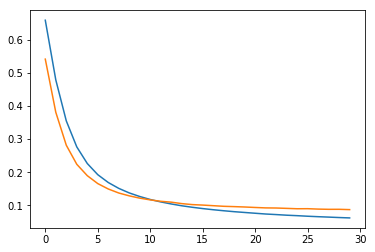

In [76]:
# Plot the results of the training.
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label="Training loss")
plt.plot(history.history['val_loss'], label="Validation loss")
plt.show()

In [0]:


# Create the encoder model from the tensors we previously declared.
encoder_model = Model(encoder_inputs, [encoder_out, state_h, state_c])

# Generate a new set of tensors for our new inference decoder. Note that we are using new tensors, 
# this does not preclude using the same underlying layers that we trained on. (e.g. weights/biases).

inf_decoder_inputs = Input(shape=(None,), name="inf_decoder_inputs")
# We'll need to force feed the two state variables into the decoder each step.
state_input_h = Input(shape=(units*2,), name="state_input_h")
state_input_c = Input(shape=(units*2,), name="state_input_c")
decoder_res, decoder_h, decoder_c = decoder_lstm(
    decoder_emb(inf_decoder_inputs), 
    initial_state=[state_input_h, state_input_c])
inf_decoder_out = decoder_d2(decoder_d1(decoder_res))
inf_model = Model(inputs=[inf_decoder_inputs, state_input_h, state_input_c], 
                  outputs=[inf_decoder_out, decoder_h, decoder_c])



In [0]:
# Converts the given sentence (just a string) into a vector of word IDs
# Output is 1-D: [timesteps/words]

def sentence_to_vector(sentence, lang):

    pre = sentence
    vec = np.zeros(len_input)
    sentence_list = [lang.word2idx[s] for s in pre.split(' ')]
    for i,w in enumerate(sentence_list):
        vec[i] = w
    return vec

# Given an input string, an encoder model (infenc_model) and a decoder model (infmodel),
def translate(input_sentence, infenc_model, infmodel):
    sv = sentence_to_vector(input_sentence, input_lang)
    sv = sv.reshape(1,len(sv))
    [emb_out, sh, sc] = infenc_model.predict(x=sv)
    
    i = 0
    start_vec = target_lang.word2idx["<start>"]
    stop_vec = target_lang.word2idx["<end>"]
    
    cur_vec = np.zeros((1,1))
    cur_vec[0,0] = start_vec
    cur_word = "<start>"
    output_sentence = ""

    while cur_word != "<end>" and i < (len_target-1):
        i += 1
        if cur_word != "<start>":
            output_sentence = output_sentence + " " + cur_word
        x_in = [cur_vec, sh, sc]
        [nvec, sh, sc] = infmodel.predict(x=x_in)
        cur_vec[0,0] = np.argmax(nvec[0,0])
        cur_word = target_lang.idx2word[np.argmax(nvec[0,0])]
    return output_sentence

In [107]:
#Note that only words that we've trained the model on will be available, otherwise you'll get an error.


# test = [
#     'hi there',
#     'hell',
#     'presentation please fin',
#     'resignation please find at',
#     'resignation please ',
#     'have a nice we',
#     'let me ',
#     'promotion congrats ',
#     'christmas Merry ',
#     'please rev',
#     'please ca',
#     'thanks fo',
#     'Let me kno',
#     'Let me know if y',
#     'this soun',
#     'is this call going t'
# ]

test = [
    'A woman wearing a bl',
    'A man wor',
    'A man is instr',
    'A city str',
    'A large man wea',
    'Man remov',
    'Seve',
    'person is atte',
    'wearing je',
    'standing out',
    'people in different co',
    'dog ru',
    'biker is ri',
    'Blond girl in a yel',
    'A person is walking al',
    'A you',
    'A young fem',
    'A young female i',
    'A young female is si',
    'A young female is sitting i',
    'A young female is sitting in a c',
    'A young female is sitting in a chair o',
    'A young female is sitting in a chair on th',
    'A young female is sitting in a chair on the be',
    'A young female is sitting in a chair on the beach , wh'
]
  

import pandas as pd
output = []  
for t in test:  
  output.append({"Input seq":t.lower(), "Pred. Seq":translate(t.lower(), encoder_model, inf_model)})

results_df = pd.DataFrame.from_dict(output) 
results_df.head(len(test))

,Input seq,Pred. Seq
0,a woman wearing a bl,ack shirt and black pants is reading a book on a tank grill .
1,a man wor,ks on a project using a jigsaw cutting machine .
2,a man is instr,it in a green shirt and a little boy in a bathing suit playing in the sand .
3,a city str,an is performing a trick in restaurant .
4,a large man wea,an illinois tshirt is looking at a camera while a girl is aiming her foot at his face and another man is making an odd face in the background .
5,man remov,ing a reflective vest sits on the sidewalk and laughing .
6,seve,ral people are taking a break while on a snowmobiling ride .
7,person is atte,ating a burger while the man next to her touching his hat .
8,wearing je,oy in a blue shirt and red hat is looking at his thumb on one hand while holding glasses in his other hand .
9,standing out,"ired man in a suit , with a blue bucket and shovel on the shore of the ocean ."


In [88]:
# This is to save the model for the web app to use for generation
from keras.models import model_from_json
from keras.models import load_model

# serialize model to JSON
#  the keras model which is trained is defined as 'model' in this example
model_json = inf_model.to_json()


with open("./sample_data/model_num.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
inf_model.save_weights("./sample_data/model_num.h5")

Using TensorFlow backend.
